# Data

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

os.chdir("/content/drive/MyDrive/Text_Mining_Project_Amazon/")
!pwd

/content/drive/MyDrive/Text_Mining_Project_Amazon


In [ ]:
df = pd.read_csv("AmazonFinal_general.csv")

In [ ]:
conditions = [
    (df['Score'] <= 3),
    (df['Score'] >= 4)
    ]
values = [ 'Negative' , 'Positive']
df['Polarity'] = np.select(conditions, values)

In [ ]:
df.Polarity.unique()

array(['Positive', 'Negative'], dtype=object)

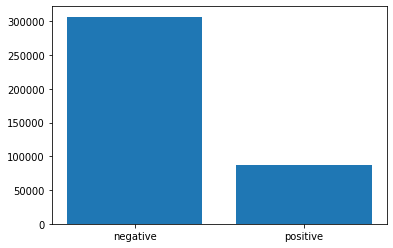

In [ ]:
classes = df.Polarity.unique()
counts = []

for i in classes:
  count = len(df[df.Polarity==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

In [ ]:
for i in classes:
  count = len(df[df.Polarity==i])
  print(count)

306887
86848


In [ ]:
#df.loc[df['Polarity'] == 'positive']

positive = df.loc[df['Polarity'] == 'Positive']
negative = df.loc[df['Polarity'] == 'Negative']

In [ ]:
positive = positive.sample(n = 86848)

In [ ]:
frames = [positive, negative]
result = pd.concat(frames)

In [ ]:
df = result
df.columns

Index(['Text', 'Summary', 'Score', 'Polarity'], dtype='object')

In [ ]:
df.shape

(173708, 3)

## Train/test split

We use the hole sample and then split taht into 80% for training and 20% for testing.

In [ ]:
sample_size = int(len(df)*1)
sampleDf = df.sample(sample_size, random_state=23)
x = sampleDf.Text.values
y = sampleDf.Polarity.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

## Tokenization
we do not count each token occurence in the text. Instead we just turn words into tokens and that's about it. we keep the order of the words intact.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  

Our tokenized dataset will essentially consist of index of each word that is used in training dataset. We can check how it looks by simply printing the first text both as it was and after tokenization.

In [ ]:
print(x_train[0])
print(X_train[0])

roasted chickpeas long time thought would wonderful time saver sadly mistaken chickpeas dry chalky hard swallow without large volume water guess return roasting
[745, 7227, 139, 24, 72, 3, 232, 24, 2764, 1318, 6370, 7227, 180, 2538, 110, 1923, 99, 266, 2095, 36, 312, 499, 3143]


## Padding
Before modelling we want to make sure our inputs are the same size, since we are using neural network with a fixed input size. \\
First we figure out the max len.

In [ ]:
lens_train = [len(i) for i in X_train]
lens_test = [len(i) for i in X_test]
lens = lens_train + lens_test

maxlen = np.max(lens)

print('Max len:', maxlen)

Max len: 1974


Then we pad our inputs to fit that size.

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

## Label Encoding

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

# Modelling
The model that we use here is a simple Neural Network. I'll add some comments to explain what each line does.

In [ ]:
embedding_dim = 100  #300 is better? 

model = Sequential()  
model.add(layers.Embedding(input_dim=vocab_size,  
                          output_dim=embedding_dim,  
                          input_length=maxlen))  
model.add(layers.Dropout(0.2))  
model.add(layers.GlobalMaxPool1D())  
model.add(layers.Dropout(0.2))
model.add(layers.Dense(50, activation='relu')) 
model.add(layers.Dropout(0.2))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax')) 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1974, 100)         12110000  
                                                                 
 dropout_8 (Dropout)         (None, 1974, 100)         0         
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                      

In [ ]:
history = model.fit(X_train, dummy_y_train,
                    epochs=3, 
                    verbose=True,
                    validation_data=(X_test, dummy_y_test),
                    batch_size=128)  
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/3
1086/1086 [==============================] - 57s 50ms/step - loss: 0.4356 - accuracy: 0.7961 - val_loss: 0.3636 - val_accuracy: 0.8442
Epoch 2/3
1086/1086 [==============================] - 54s 50ms/step - loss: 0.3510 - accuracy: 0.8477 - val_loss: 0.3503 - val_accuracy: 0.8486
Epoch 3/3
1086/1086 [==============================] - 54s 50ms/step - loss: 0.3154 - accuracy: 0.8641 - val_loss: 0.3479 - val_accuracy: 0.8482
Training Accuracy: 0.9056
Testing Accuracy:  0.8482


In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

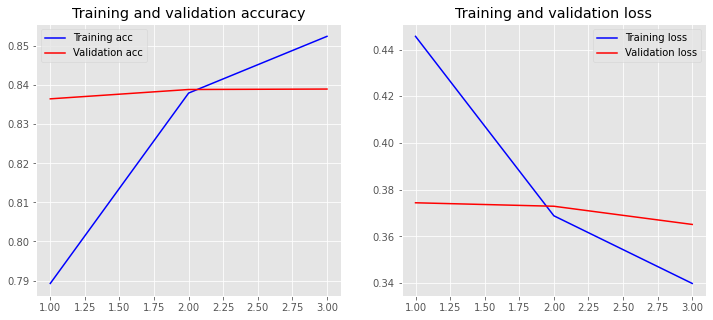

In [ ]:
plot_history(history)



Essentially model is prone to overtrain


#Confussion matrix


So here we need to do it a bit differently from the way we did it in the Logistic Regression notebook. We have encoded our classses using encoder. Here are those classes.

In [ ]:
encoder.classes_

array(['Negative', 'Positive'], dtype=object)

And our predictions are stored as arrays with probabilities fir each class.

In [ ]:
y_pred = model.predict(X_test)
y_pred

array([[0.6929716 , 0.3070284 ],
       [0.15371765, 0.84628236],
       [0.89833874, 0.10166123],
       ...,
       [0.59680563, 0.40319437],
       [0.77597535, 0.22402465],
       [0.5974896 , 0.40251037]], dtype=float32)

Here you can see that we have array of arrays of 2 probabilities for each class. So we need to turn those into classes.

In [ ]:
y_predDecoded = [encoder.classes_[np.argmax(i)] for i in y_pred]  
cm = confusion_matrix(y_test, y_predDecoded, labels=df.Polarity.unique()) 
df_cm = pd.DataFrame(cm, index=df.Polarity.unique(), columns=df.Polarity.unique())
df_cm

,Positive,Negative
Positive,14690,2655
Negative,2617,14778


For a better understanding you could use percentage expression.

In [ ]:
df_cm_percentage = df_cm.copy()
for i in df_cm_percentage:
  df_cm_percentage[i]/=df_cm_percentage[i].sum()

df_cm_percentage

,Positive,Negative
Positive,0.84879,0.152297
Negative,0.15121,0.847703


The results are similar to the Logistic Regression.

# Test

In [ ]:
text = 'find barilla pasta really good italy is perfect match for fine food'
vectText = tokenizer.texts_to_sequences(np.array([text]))  # vectorizes the text using our vectorizer
vectText = pad_sequences(vectText, padding='post', maxlen=maxlen)  # adds padding

prediction = model.predict(vectText)  # predicts class of the text
print('Text is', 'positive' if encoder.classes_[np.argmax(prediction)]==4 else 'negative')

In [ ]:
textList = ['barilla pasta really good', 'this barilla pasta sucks bad']
vectText = tokenizer.texts_to_sequences(np.array(textList))  # vectorizes the text using our vectorizer
vectText = pad_sequences(vectText, padding='post', maxlen=maxlen)  # adds padding

prediction = model.predict(vectText)  # predicts class of the text
for enum, i in enumerate(textList):
  print(i, '| This text is', 'positive' if encoder.classes_[np.argmax(prediction[enum])]==4 else 'negative')